## Tweet Emotion Recognition with TensorFlow


## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 1.3 MB/s 
     |████████████████████████████████| 243 kB 7.1 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


In [3]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

|          | 0/0 [00:00<?, ? examples/s]

|          | 0/0 [00:00<?, ? examples/s]

|          | 0/0 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [8]:
tweets, labels = get_tweets(train)

In [9]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Tokenizing the tweets

In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[3]]))

[[2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497]]


## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

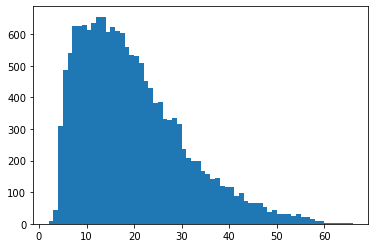

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [12]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [13]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [14]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [15]:
classes = set(labels)
print(classes)

{'fear', 'joy', 'sadness', 'love', 'surprise', 'anger'}


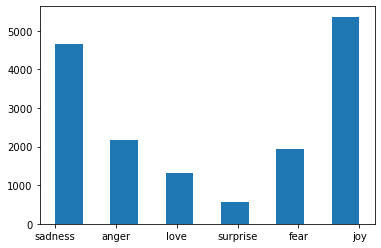

In [16]:
plt.hist(labels, bins=11)
plt.show()

In [17]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [18]:
classes_to_index

{'fear': 0, 'joy': 1, 'sadness': 2, 'love': 3, 'surprise': 4, 'anger': 5}

In [19]:
index_to_classes

{0: 'fear', 1: 'joy', 2: 'sadness', 3: 'love', 4: 'surprise', 5: 'anger'}

In [20]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [21]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


## Creating and Compiling the Model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [23]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [24]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [25]:
history = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/50
500/500 [==============================] - 15s 17ms/step - loss: 1.5133 - accuracy: 0.3775 - val_loss: 0.7509 - val_accuracy: 0.7320
Epoch 2/50
500/500 [==============================] - 7s 14ms/step - loss: 0.5980 - accuracy: 0.7623 - val_loss: 0.6104 - val_accuracy: 0.7730
Epoch 3/50
500/500 [==============================] - 7s 14ms/step - loss: 0.3859 - accuracy: 0.8603 - val_loss: 0.4986 - val_accuracy: 0.8410
Epoch 4/50
500/500 [==============================] - 8s 16ms/step - loss: 0.2377 - accuracy: 0.9247 - val_loss: 0.4622 - val_accuracy: 0.8630
Epoch 5/50
500/500 [==============================] - 7s 14ms/step - loss: 0.1572 - accuracy: 0.9494 - val_loss: 0.3995 - val_accuracy: 0.8845
Epoch 6/50
500/500 [==============================] - 7s 14ms/step - loss: 0.1004 - accuracy: 0.9701 - val_loss: 0.3831 - val_accuracy: 0.8855
Epoch 7/50
500/500 [==============================] - 7s 14ms/step - loss: 0.0884 - accuracy: 0.9725 - val_loss: 0.4467 - val_accuracy: 0.886

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

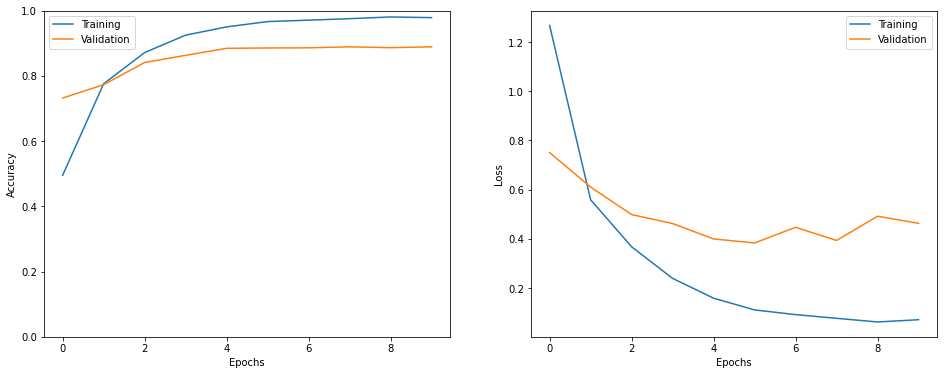

In [26]:
show_history(history)

In [27]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [28]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4853 - accuracy: 0.8800


In [29]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]
print('Predicted Emotion:', index_to_classes.get(p))

Sentence: i got the sleep but if i could choose not to be woken up by an alarm i d definitely take that over anything it makes me feel so groggy
Emotion: sadness


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted Emotion: sadness


In [30]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

((2000,), (2000,))

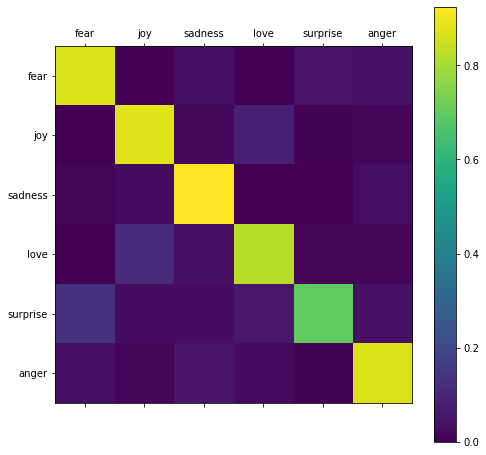

In [31]:
show_confusion_matrix(test_labels, preds, list(classes))

### Reference
- [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)
- [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/learn/tweet-emotion-tensorflow)